In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)


import numpy as np
import time
import pickle

import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
from tueplots import bundles

from bocpd import bocpd
from hazard import ConstantHazard
from models import GaussianUnknownMean, SMGaussianUnknownMean
from models import Gaussian, DSMGaussian
from models import MultivariateGaussian, DSMMultivariateGaussian 
from models import MultivariateGaussianUnkownMean, DSMMultivariateGaussianUnkownMean
from utils.generate_data import generate_data
from utils.find_cp import find_cp

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
RESULT_PATH = os.path.join(SCRIPT_DIR,'data/complexity')

In [3]:
np.random.seed(3000)

T = [100, 500, 1000, 5000, 10000, 15000, 20000] # Number of observations.
datasets_T = []
cps = []
n_cps = 1
for t in T:
    data = np.random.normal(size=t)
    datasets_T.append(data.reshape([t,1]))

In [32]:
np.random.seed(3000)
t = 100
D = [1, 5, 10, 50, 100, 200, 300, 400, 500] # data dimension.
datasets_D = []
cps = []
real_cp = 500
for d in D:
    mean  = np.zeros(d)     
    cov   = np.eye(d) 
    data = np.random.multivariate_normal(mean, cov, size=t)
    datasets_D.append(data.reshape([t,d]))

# Mean

## Increasing number of observation

In [33]:
times_BOCD_T_mean = []
for dataset, t in zip(datasets_T,T):
    print(t,'observations')
    model  = GaussianUnknownMean(0, 1, 1)
    hazard = ConstantHazard(t/(n_cps+1))
    start_time = time.time()
    bocpd(dataset, hazard, model)
    end_time = time.time()
    times_BOCD_T_mean.append(end_time-start_time)

100 observations
500 observations
1000 observations
5000 observations
10000 observations
15000 observations


/home/maltamirano/Documents/DSM-bocd/bocpd.py:58: RuntimeWarning: invalid value encountered in exp
  R = np.exp(log_R)


20000 observations


In [6]:
file_name = os.path.join(RESULT_PATH,'times_BOCD_T_mean.pickle')
with open(file_name, 'wb') as handle:
    pickle.dump(times_BOCD_T_mean, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
def grad_r(x):
    return np.eye(1)

def grad_b(x):
    return -x

def lap_r(x):
    return np.zeros(1)

In [8]:
times_DSM_T_mean = []
omega = 1
for dataset, t in zip(datasets_T,T):
    print(t,' observations')
    model = SMGaussianUnknownMean(data, grad_r, lap_r, grad_b, omega, 0, 1, 1)
    hazard = ConstantHazard(t/(n_cps+1))
    start_time = time.time()
    bocpd(dataset, hazard, model)
    end_time = time.time()
    times_DSM_T_mean.append(end_time-start_time)

100  observations
500  observations
1000  observations
5000  observations
10000  observations
15000  observations
20000  observations


In [9]:
file_name = os.path.join(RESULT_PATH,'times_DSM_T_mean.pickle')
with open(file_name, 'wb') as handle:
    pickle.dump(times_DSM_T_mean, handle, protocol=pickle.HIGHEST_PROTOCOL)

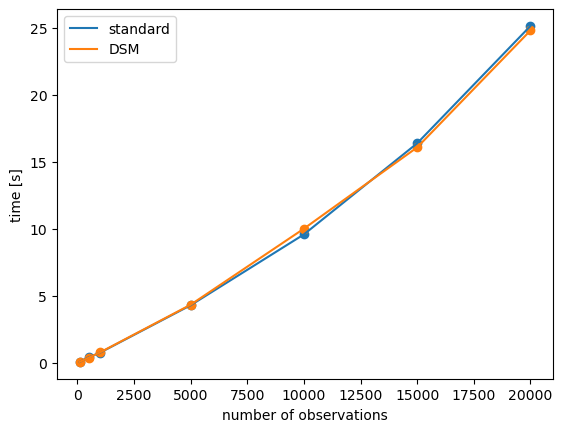

In [10]:
plt.plot(T,times_BOCD_T_mean,label = 'standard')
plt.scatter(T,times_BOCD_T_mean)
plt.plot(T,times_DSM_T_mean, label ='DSM')
plt.scatter(T,times_DSM_T_mean)
plt.ylabel('time [s]')
plt.xlabel('number of observations')
plt.legend()

## Increasing data dimension

In [34]:
times_BOCD_D_mean = []
for dataset, d in zip(datasets_D,D):
    print('Dimension = ',d )
    mu0 = np.zeros((d,1))
    Sigma0 = np.eye(d)
    Cov = np.eye(d)
    
    model  = MultivariateGaussianUnkownMean(mu0, Sigma0, Cov, d)
    hazard = ConstantHazard(t)
    start_time = time.time()
    bocpd(dataset, hazard, model)
    end_time = time.time()
    times_BOCD_D_mean.append(end_time-start_time)

Dimension =  1
Dimension =  5
Dimension =  10
Dimension =  50
Dimension =  100
Dimension =  200
Dimension =  300
Dimension =  400
Dimension =  500


In [35]:
file_name = os.path.join(RESULT_PATH,'times_BOCD_D_mean.pickle')
with open(file_name, 'wb') as handle:
    pickle.dump(times_BOCD_D_mean, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
times_DSM_D_mean = []
omega = 0.1
for dataset, d in zip(datasets_D,D):
    print('Dimension = ',d )
    def m(x):
        return np.eye(d)

    def grad_m(x):
        m = np.zeros((d,d,d))
        return np.zeros((d,d,d))
    
    mu0 = np.zeros((d,1))
    Sigma0 = np.eye(d)
    Cov = np.eye(d)
    
    model = DSMMultivariateGaussianUnkownMean(dataset, m ,grad_m, omega, mu0, Sigma0, Cov, d=d)
    hazard = ConstantHazard(t)
    start_time = time.time()
    bocpd(dataset, hazard, model)
    end_time = time.time()
    times_DSM_D_mean.append(end_time-start_time)

Dimension =  1
Dimension =  5
Dimension =  10
Dimension =  50
Dimension =  100
Dimension =  200
Dimension =  300
Dimension =  400
Dimension =  500


In [37]:
file_name = os.path.join(RESULT_PATH,'times_DSM_D_mean.pickle')
with open(file_name, 'wb') as handle:
    pickle.dump(times_DSM_D_mean, handle, protocol=pickle.HIGHEST_PROTOCOL)

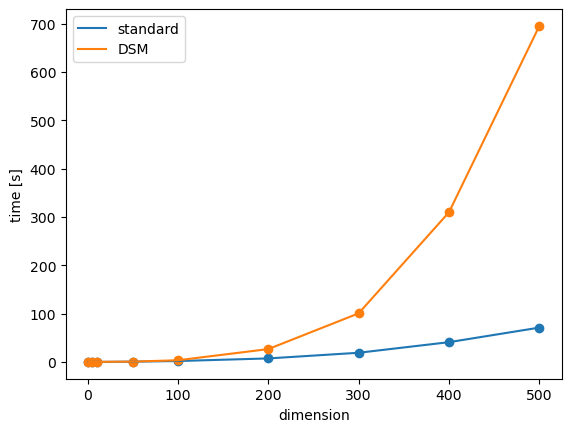

In [38]:
plt.plot(D,times_BOCD_D_mean,label = 'standard')
plt.scatter(D,times_BOCD_D_mean)
plt.plot(D,times_DSM_D_mean, label ='DSM')
plt.scatter(D,times_DSM_D_mean)
plt.ylabel('time [s]')
plt.xlabel('dimension')
plt.legend()

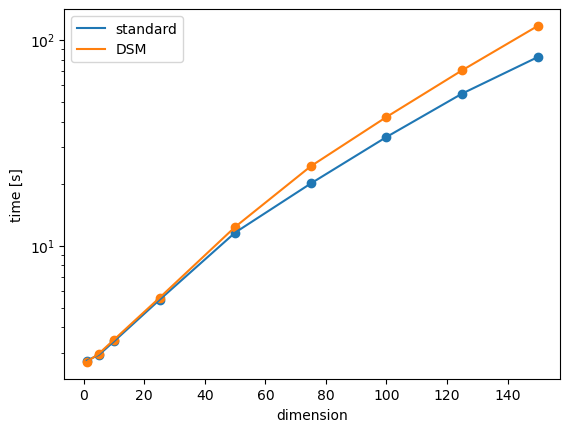

In [24]:
plt.plot(D,times_BOCD_D_mean,label = 'standard')
plt.scatter(D,times_BOCD_D_mean)
plt.plot(D,times_DSM_D_mean, label ='DSM')
plt.scatter(D,times_DSM_D_mean)
plt.yscale('log')
plt.ylabel('time [s]')
plt.xlabel('dimension')
plt.legend()

# Mean and Variance

## increasing number of Observations

In [17]:
times_BOCD_T = []
for dataset, t in zip(datasets_T,T):
    print(t,'observations')
    model  = Gaussian(mu0=0, kappa0=1,alpha0=1,omega0=1)
    hazard = ConstantHazard(t)
    start_time = time.time()
    bocpd(dataset, hazard, model)
    end_time = time.time()
    times_BOCD_T.append(end_time-start_time)

100 observations
500 observations
1000 observations
5000 observations
10000 observations
15000 observations
20000 observations


In [18]:
file_name = os.path.join(RESULT_PATH,'times_BOCD_T.pickle')
with open(file_name, 'wb') as handle:
    pickle.dump(times_BOCD_T, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
times_DSM_T = []

def m(x):
    return np.eye(1)

def grad_m(x):
    m = np.zeros((1,1,1))
    return np.zeros((1,1,1))

mu0 = np.array([1,0]).reshape(2,1)
Sigma0 = np.eye(2)

omega = 1

for dataset, t in zip(datasets_T,T):
    print(t,'observations')
    
    model  = DSMGaussian(dataset, m, grad_m, omega, mu0, Sigma0)
    hazard = ConstantHazard(t)
    start_time = time.time()
    bocpd(dataset, hazard, model)
    end_time = time.time()
    times_DSM_T.append(end_time-start_time)

100 observations
500 observations
1000 observations
5000 observations
10000 observations
15000 observations
20000 observations


In [20]:
file_name = os.path.join(RESULT_PATH,'times_DSM_T.pickle')
with open(file_name, 'wb') as handle:
    pickle.dump(times_DSM_T, handle, protocol=pickle.HIGHEST_PROTOCOL)

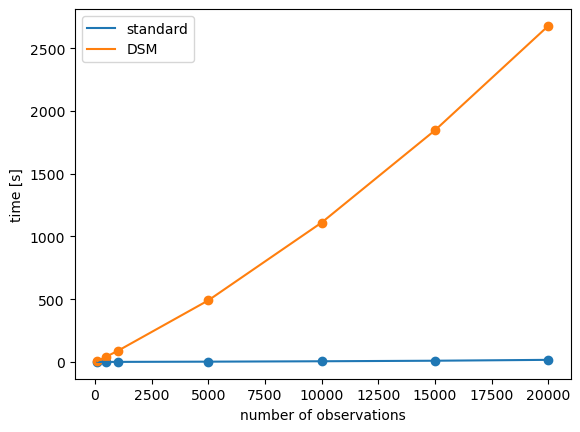

In [21]:
plt.plot(T,times_BOCD_T,label = 'standard')
plt.scatter(T,times_BOCD_T)
plt.plot(T,times_DSM_T, label ='DSM')
plt.scatter(T,times_DSM_T)
plt.ylabel('time [s]')
plt.xlabel('number of observations')
plt.legend()

## Dimensions

In [39]:
np.random.seed(3000)
t = 100
D = [1, 5, 10, 20, 30, 40, 50] # data dimension.
datasets_D = []
cps = []
real_cp = 500
for d in D:
    mean  = np.zeros(d)     
    cov   = np.eye(d) 
    data = np.random.multivariate_normal(mean, cov, size=t)
    datasets_D.append(data.reshape([t,d]))

In [40]:
times_BOCD_D = []
for dataset, d in zip(datasets_D,D):
    print('Dimension = ',d )
    mu0 = np.zeros((d,1))
    Sigma0 = np.eye(d)
    Cov = np.eye(d)
    
    model  = MultivariateGaussian(d=d)
    hazard = ConstantHazard(t)
    start_time = time.time()
    bocpd(dataset, hazard, model)
    end_time = time.time()
    times_BOCD_D.append(end_time-start_time)

Dimension =  1
Dimension =  5
Dimension =  10
Dimension =  20
Dimension =  30
Dimension =  40
Dimension =  50


In [41]:
file_name = os.path.join(RESULT_PATH,'times_BOCD_D.pickle')
with open(file_name, 'wb') as handle:
    pickle.dump(times_BOCD_D, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
times_DSM_D = []
omega = 1
for dataset, d in zip(datasets_D,D):
    print('Dimension = ',d )
    def m(x):
        return np.eye(d)

    def grad_m(x):
        m = np.zeros((d,d,d))
        return np.zeros((d,d,d))
    
    mu0 = np.zeros((2*d,1))
    for i in range(d):
        mu0[2*i+1]=1
    Sigma0 = np.eye(2*d)
    
    
    model = DSMMultivariateGaussian(dataset, m ,grad_m, omega, mu0, Sigma0, d=d, b=10)
    hazard = ConstantHazard(t)
    start_time = time.time()
    bocpd(dataset, hazard, model)
    end_time = time.time()
    times_DSM_D.append(end_time-start_time)

Dimension =  1
Dimension =  5
Dimension =  10
Dimension =  20
Dimension =  30
Dimension =  40
Dimension =  50


In [43]:
file_name = os.path.join(RESULT_PATH,'times_DSM_D.pickle')
with open(file_name, 'wb') as handle:
    pickle.dump(times_DSM_D, handle, protocol=pickle.HIGHEST_PROTOCOL)

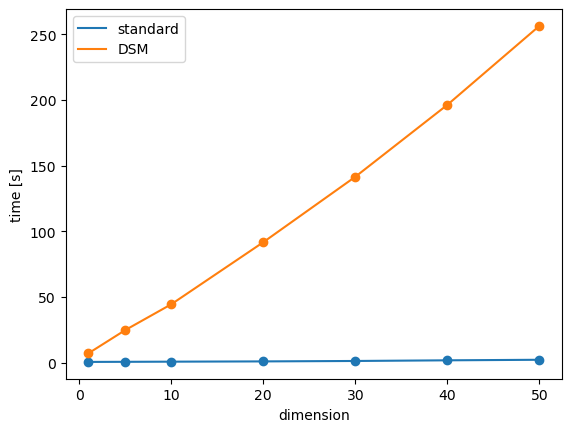

In [44]:
plt.plot(D,times_BOCD_D,label = 'standard')
plt.scatter(D,times_BOCD_D)
plt.plot(D,times_DSM_D, label ='DSM')
plt.scatter(D,times_DSM_D)
plt.ylabel('time [s]')
plt.xlabel('dimension')
plt.legend()

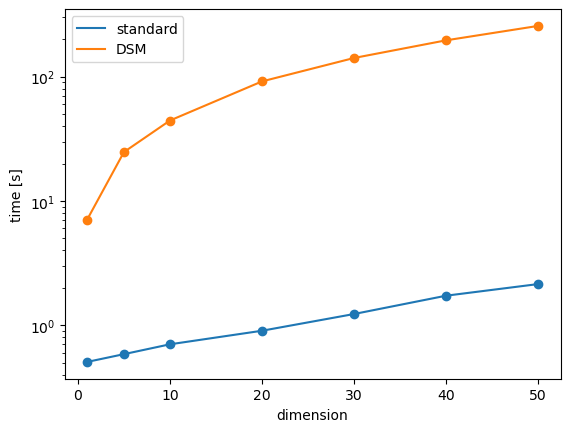

In [45]:
plt.plot(D,times_BOCD_D,label = 'standard')
plt.scatter(D,times_BOCD_D)
plt.plot(D,times_DSM_D, label ='DSM')
plt.scatter(D,times_DSM_D)
plt.yscale('log')
plt.ylabel('time [s]')
plt.xlabel('dimension')
plt.legend()

In [46]:
times_DSM_D

[7.066813230514526,
 24.74167037010193,
 44.390377044677734,
 91.64902710914612,
 141.45967483520508,
 196.2095365524292,
 256.3089418411255]

In [47]:
D

[1, 5, 10, 20, 30, 40, 50]